# Imporación de paquetes y montaje de Google Drive

In [ ]:
#Importación de paquetes
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FF

import torch.optim as optim

from PIL import Image

#Activación de la GPU proporcionada por Google Colab
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

!nvidia-smi

Fri Aug 23 15:07:10 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
#Activación del acceso a Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Definición de las rutas de las bases de datos para entrenamiento y prueba
PATH = '/content/drive/MyDrive/Nube /UNL_Automatizacion y Robotica/Proyecto_final_de_la_carrera/imagenes_frascos'
PATH_TEST = '/content/drive/MyDrive/Nube /UNL_Automatizacion y Robotica/Proyecto_final_de_la_carrera/imagenes_frascos_test'

Mounted at /content/drive


# Funciones


In [ ]:
#Definición de una función para levantar las imagenes para entrenamiento desde una
#carpeta principal compuesta por subcarpetas divididas por las diferentes clases
def cargar_imagenes_entrenamiento(main_folder, image_size = (1080, 1920), train_test_ratio = [0.8, 0.2], image_batch_size = 16):

    #Definición de las transformaciones de aumento de datos (pueden realizarse
    #otras transformaciones activando las líneas comentadas)
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
        #transforms.Resize(image_size),
        #transforms.RandomHorizontalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.2, contrast=0.9, saturation=0.2, hue=0.1),  # Cambio de color
        #transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=0.01, translate=(0.1, 0.1)),
        #transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        #transforms.RandomGrayscale(p=0.2),
        torchvision.transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    #Creación de un dataset con todas las imágenes separadas por clases y le
    #aplico las transformaciones anteriores
    dataset = ImageFolder(main_folder, transform=train_transform)

    #Partiendo del dataset general, se crean los datasets de entrenamiento y
    #validación utilizando la proporción especificada
    train_dataset_f, val_dataset_f = torch.utils.data.random_split(dataset,
                                                                train_test_ratio,
                                                                generator=torch.Generator().manual_seed(42))


    #Se devuelven los datasets creados
    return train_dataset_f, val_dataset_f

In [ ]:
#Definición de una función para levantar las imagenes de test desde una carpeta
#compuesta por subcarpetas divididas por las diferentes clases
def cargar_imagenes_test(folder, image_size = (1080, 1920), image_batch_size = 16):

    #Definición de una transformación que ajusta el tamaño de las imágenes y las
    #convierte en tensores. No se aplican técnicas de ampliación de datos
    test_transform = transforms.Compose([
        transforms.Resize(image_size),  # Ajusta el tamaño de las imágenes a 224x224 píxeles
        transforms.ToTensor()  # Convierte las imágenes en tensores de PyTorch
    ])


    #Creación de un dataset con todas las imágenes de test separadas por clases
    test_dataset_f = ImageFolder(folder, transform=test_transform)

    #Se devuelve el dataset creado
    return test_dataset_f

In [ ]:
#Función para crear un dataloader a partir de un dataset proporcionado por el usuario
def crear_dataloader(dataset_user, images_bach_size = 16, shuffle_user=True):

    #Creación de un dataloader con el dataset disponible y con el tamaño de baches deseado
    dataloader_user = DataLoader(dataset_user,
                                     batch_size=images_bach_size,
                                     shuffle=shuffle_user)

    #Se devuelve el dataset creado
    return dataloader_user

In [ ]:
#Función para mostrar imagenes
def imshow(img):
    #Se revierte la normalización colocando los valores de los pixeles en el
    #rango de [0, 1]
    img = img / 2 + 0.5

    #Se transforma el tensor de imágenes en un arreglo de numpy
    npimg = img.numpy()

    #Se reordena el arreglo anterior al formato (altura, anchura, canales)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    #Se muestran las imágenes
    plt.show()

# Visualización de datos

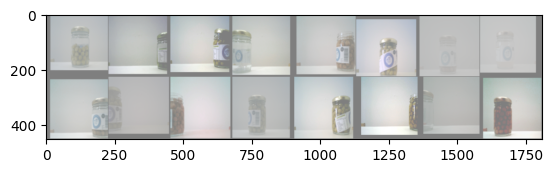

In [ ]:
#Denición del tamaño de lote
batch_size = 16

#Creación de los datasets para entrenamiento, validación y prueba
train_dataset, val_dataset = cargar_imagenes_entrenamiento(PATH, (224, 224))
test_dataset = cargar_imagenes_test(PATH_TEST, (224, 224))


#Creación de los dataloader para entrenamiento, validación y prueba
train_dataloader = crear_dataloader(train_dataset)
val_dataloader = crear_dataloader(val_dataset)
test_dataloader = crear_dataloader(test_dataset)


#Creación de una tupla con los numbres de las clases
classes = ('correcto', 'vacio', 'faltan_arbejas', 'falta_liquido',
           'falta_etiqueta', 'etiqueta_mala', 'falta_tapa', 'tapa_mala')


#Conversión del dataloader de entrenamiento en un iterador
dataiter = iter(train_dataloader)
#Obtención de las imágenes y etiquetas por separado
images, labels = next(dataiter)

#Se muestran las imágenes en una cuadrícula
imshow(torchvision.utils.make_grid(images))
#Se imprimen las clases reales de las imágenes mostradas
print('       '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

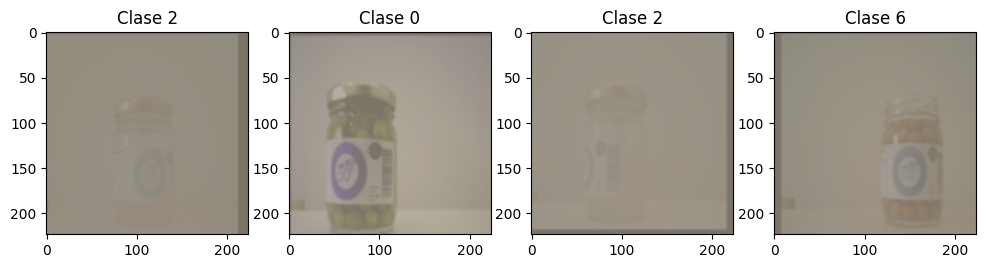

In [ ]:
#Obtención de un lote de datos aumentados
batch = next(iter(train_dataloader))
images, labels = batch

#Desnormalización las imágenes si se aplicó normalización durante la transformación
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
images = images * std.reshape(1, 3, 1, 1) + mean.reshape(1, 3, 1, 1)

#Conversión del tensor de PyTorch a un arreglo NumPy
images = images.numpy()

#Graficación de algunas de las imágenes obtenidas con su clase correspondiente
num_images_to_show = 4
fig, axes = plt.subplots(1, num_images_to_show, figsize=(12, 3))

for i in range(num_images_to_show):
    axes[i].imshow(np.transpose(images[i], (1, 2, 0)))
    axes[i].set_title(f"Clase {labels[i]}")

plt.show()

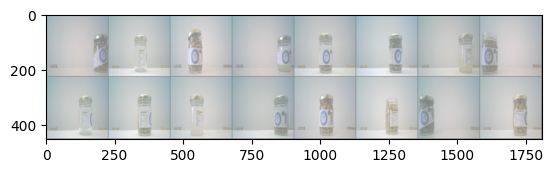

etiqueta_mala       vacio       tapa_mala       faltan_arbejas       falta_liquido       correcto       faltan_arbejas       falta_tapa       vacio       falta_liquido       faltan_arbejas       falta_liquido       correcto       falta_tapa       etiqueta_mala       correcto


In [ ]:
#Transformación del dataloader en un iterador
dataiter = iter(test_dataloader)
#Obtención de las imágenes y etiquetas por separado
images, labels = next(dataiter)

#Se muestran las imagenes en una grilla
imshow(torchvision.utils.make_grid(images))
#Se muestran las etiquetas de las imágenes graficadas
print('       '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Modelo neuronal

In [ ]:
#Creación del modelo neuronal
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        #self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.conv5 = nn.Conv2d(64, 128, 3)


        self.fc1 = nn.Linear(3200, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Inicialización de la red
net = Net()

In [ ]:
#Definición de un criterio de error o función de pérdida
criterion = nn.CrossEntropyLoss()

# Entrenamiento

In [ ]:
#Función para evaluar el rendimiento de una red neuronal midiendo su accuracy y
#error medio
def calculate_accuracy(net, dataloader):
    #Inicialización en 0 de variables para contar cantidad de predicciones
    #correctas, total de predicciones y la acumulación del error
    correct = 0
    total = 0
    total_loss = 0

    #Definición de la función de pérdida utilizada
    criterion = nn.CrossEntropyLoss()

    #Desactivando el cálculo de gradientes
    with torch.no_grad():
        #Iterando a travez de los elementos del dataloader
        for data in dataloader:
            #Se obtienen las imágenes de entrada con sus etiquetas reales
            inputs, labels = data
            #Obtención de las predicciones realizadas por la red para las entradas
            outputs = net(inputs.to("cuda"))
            #Selección del valor de predicción de clase más alto para cada salida
            _, predicted = torch.max(outputs.data, 1)
            #Actualización del número total de muestras evaluadas
            total += labels.size(0)
            #Si la predicción fue correcta, aumenta en 1 un contador
            correct += (predicted == labels.to("cuda")).sum().item()
            #Cálculo de error o pérdida para el lote actual
            loss = criterion(outputs, labels.to("cuda"))
            #Se suma el error del lote actual al total de error
            total_loss += loss.item()

    #Cálculo de accuracy
    accuracy = 100 * correct / total
    #Cálculo del error medio
    error = total_loss / total

    #Se devuelven los valores de accuracy y error medio calculado
    return accuracy, error

In [ ]:
#Creación de estructura para guardar métricas
measures = {
            'trn_loss': [],
            'trn_acc': [],
            'val_loss': [],
            'val_acc': []
           }

Epoch 0: trn_loss: 0.13042	 val_loss: 0.13263	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 0
Epoch 1: trn_loss: 0.13042	 val_loss: 0.13264	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 0
Epoch 2: trn_loss: 0.13041	 val_loss: 0.1327	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 1
Epoch 3: trn_loss: 0.1304	 val_loss: 0.13271	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 2
Epoch 4: trn_loss: 0.1304	 val_loss: 0.1327	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 3
Epoch 5: trn_loss: 0.1304	 val_loss: 0.13267	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 4
Epoch 6: trn_loss: 0.1304	 val_loss: 0.13268	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 5
Epoch 7: trn_loss: 0.13041	 val_loss: 0.13269	 trn_acc: 12.156862745098039	 val_acc: 12.698412698412698	 counter: 6
Epoch 8: trn_loss: 0.1304	 val_loss: 0.13267	 trn_acc: 12.156862745098039	 val

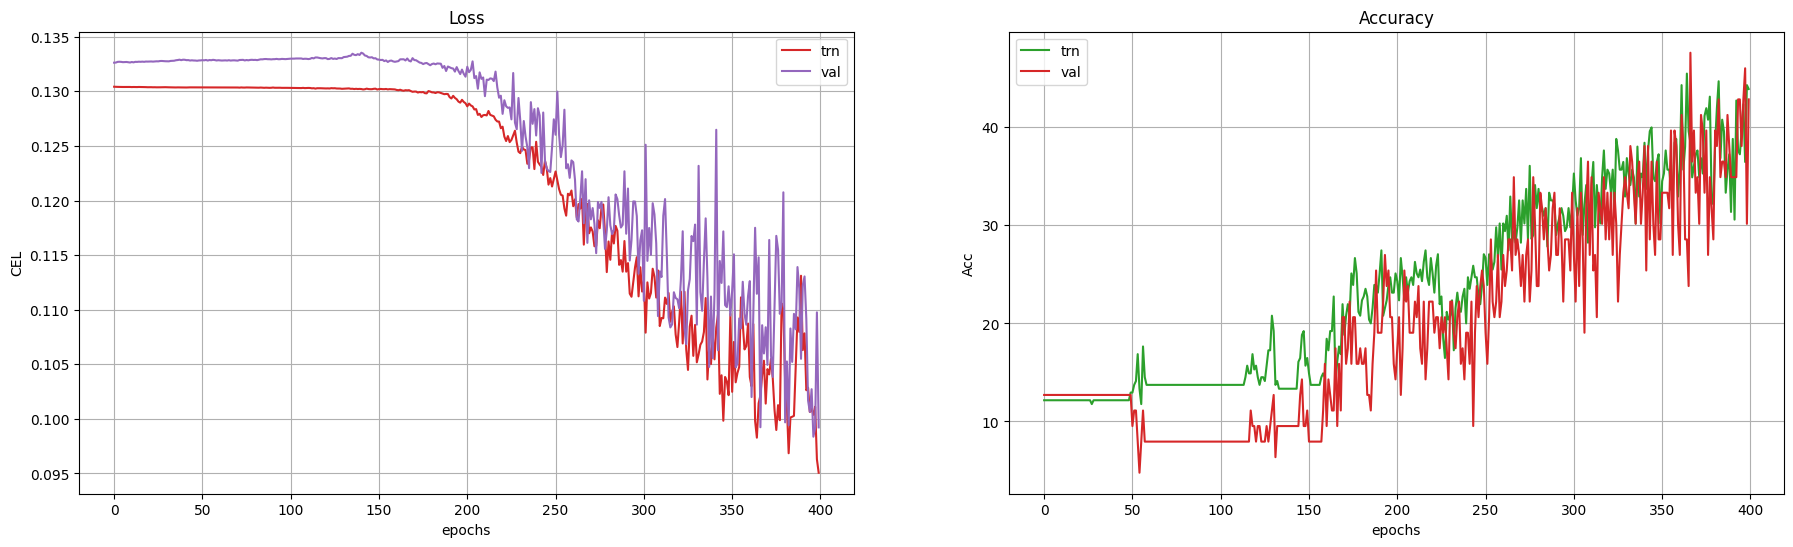

In [ ]:
#Definición de variables
counter = 0       #Contador para chequear en validación
best_loss = 1E6   #Variable para el mejor error
best_acc = 0      #Variable para el mejor accuracy
fold = 0          #Contador de epocas de entrenamiento

#Inicialización de la red neuronal
net = Net()

#Se mueve el modelo a la GPU
net = net.to("cuda")

#Definición del optimizador
optimizer = optim.Adam(net.parameters(), lr=1e-4)


#El entrenamiento durará 1o epocas o hasta que se alcanse el límite del
#contador, indicando que el modelo está memorizando los datos
while (fold < 25) and (counter < 30):
    #Reinicio de los valores de error actual, contador y mejor epoca para este fold
    running_loss = 0.0
    counter = 0
    best_epoch = 0

    #Se itera sobre el dataloader de entrenamiento
    for i, data in enumerate(train_dataloader, 0):

        #Obtención de las entradas y las etiquetas por separado
        inputs, labels = data

        #Se ponen en cero o reinicial los gradientes de los parámetros
        optimizer.zero_grad()

        #Paso hacia adelante calculando las salidas de la red
        outputs = net(inputs.to("cuda"))
        #Cálculo entre las salidas de la red y las etiquetas verdaderas
        loss = criterion(outputs, labels.to("cuda"))
        #Paso hacia atrás calculando el gradiente de la pérdida respecto a los parámetros
        loss.backward()
        #Actualización de los parámetros de la red con el optimizador
        optimizer.step()

        #Se acumula el error actual a una suma de error total
        running_loss += loss.item()

        #Se calcula el accuracy y el error medio para el dataloader de
        #entrenamiento y validación
        train_accuracy, train_loss = calculate_accuracy(net, train_dataloader)
        val_accuracy, val_loss = calculate_accuracy(net, val_dataloader)

        #Guardado de las métricas obtenidas en un diccionario
        measures['trn_loss'].append(train_loss)
        measures['trn_acc'].append(train_accuracy)
        measures['val_loss'].append(val_loss)
        measures['val_acc'].append(val_accuracy)

        #Impresión de las métricas por cada época de entrenamiento
        if (i%1) == 0:
            print(f'Epoch {i}: trn_loss: {train_loss:.5}\t val_loss: {val_loss:.5}\t trn_acc: {train_accuracy}\t val_acc: {val_accuracy}\t counter: {counter}')


        #=================================
        #Si el error actual es menor al mejor error registrado
        if (val_loss < best_loss):

            #Actualización del mejor error al error actual
            best_loss = val_loss
            #Guardado de la mejor época
            best_epoch = i
            #Actualización del mejor valor de accuracy
            best_acc = val_accuracy

            #Guardado del modelo actual como un diccionario
            best_model = net.state_dict()
            counter = 0  #Reinicio del contador

        #Si esta época no fue mejor que la anterior
        else:
            counter += 1 #Aumenta el contador en 1

    #=================================
    #Al finalizar una etapa de entranamiento, se muestan los mejores resultados
    print('-' * 30)
    print(f'Fold {fold + 1}:')
    print(f'Best Epoch: {best_epoch:}')
    print(f'Best Loss: {best_loss:.2f}')
    print(f'Best Accuracy: {best_acc:.2f}')
    print(f'Counter: {counter:}')
    print('=' * 30)

    #Se aumenta el contador de etapas
    fold += 1


#Al finalizar el entrenamiento se muestra un mensaje
print('Finished Training')

#Definición de la ruta donde se guarda el modelo entrenado
model_path = '/content/drive/MyDrive/Nube /UNL_Automatizacion y Robotica/Proyecto_final_de_la_carrera/best_model.pth'

#Guardado del modelo entrenado en el archivo
torch.save(best_model, model_path)

#Se imprime un mensaje anunciando que se guardo el modelo
print('=' * 30)
print("Modelo guardado")

#===============================================================================

#Creación de un gráfico doble
fig, ax = plt.subplots(1,2,figsize=(22,6))

#En el primer gráfico se muestran los valores de error para los dataloader de
#entrenamiento y validación
ax[0].plot(measures['trn_loss'], 'C3', label='trn')
ax[0].plot(measures['val_loss'], 'C4', label='val')
ax[0].set_title('Loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('CEL')
ax[0].grid(True)
ax[0].legend()

#En el segundo gráfico se muestran los valores de accuracy para los dataloader
#de entrenamiento y validación
ax[1].plot(measures['trn_acc'], 'C2', label='trn')
ax[1].plot(measures['val_acc'], 'C3', label='val')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Acc')
ax[1].grid(True)
ax[1].legend();

# Visualización de métricas:

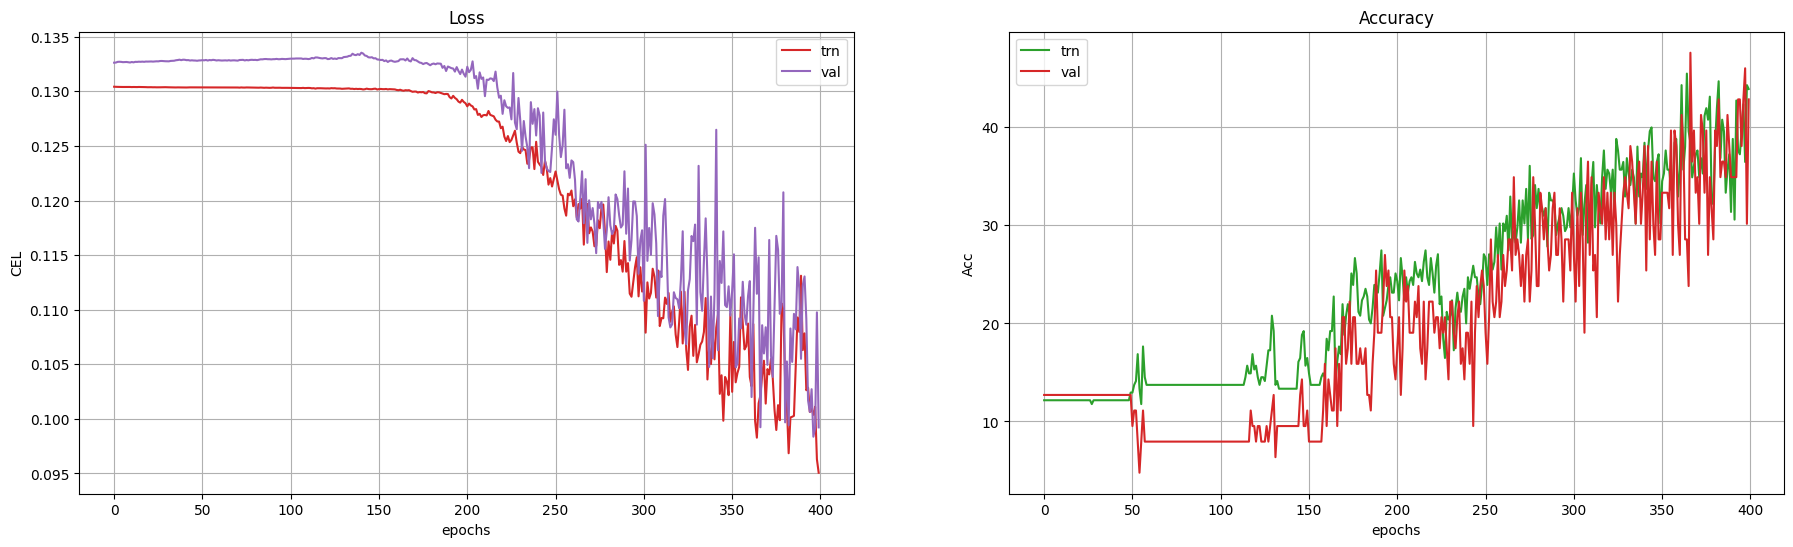

In [ ]:
#Creación de un gráfico doble
fig, ax = plt.subplots(1,2,figsize=(22,6))

#En el primer gráfico se muestran los valores de error para los dataloader de
#entrenamiento y validación
ax[0].plot(measures['trn_loss'], 'C3', label='trn')
ax[0].plot(measures['val_loss'], 'C4', label='val')
ax[0].set_title('Loss')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('CEL')
ax[0].grid(True)
ax[0].legend()

#En el segundo gráfico se muestran los valores de accuracy para los dataloader
#de entrenamiento y validación
ax[1].plot(measures['trn_acc'], 'C2', label='trn')
ax[1].plot(measures['val_acc'], 'C3', label='val')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('Acc')
ax[1].grid(True)
ax[1].legend();

# Prueba:

In [ ]:
#Inicialización de la red
net = Net()
#Se cargan en la red el mejor modelo obtenido
net.load_state_dict(best_model)
net = net.to("cuda")

#Cálculo del error y accuracy en test
test_accuracy, test_loss = calculate_accuracy(net, test_dataloader)

#Se imprimen en la pantalla los resultados de error medio y accuracy en prueba
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.0795
Test Accuracy: 57.5000
